In [2]:
%config Completer.use_jedi = False

In [3]:
import random
import os
import cv2
import json
import tqdm
import matplotlib
from matplotlib import image, patches
import matplotlib.pyplot as pyplot
import seaborn as sns
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

## Evaluation Helper Functions

In [4]:
def bb_intersection_over_union(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

     # compute the area of intersection rectangle
    interArea = abs(max((xB - xA, 0)) * max((yB - yA), 0))
    if interArea == 0:
        return 0

    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = abs((boxA[2] - boxA[0]) * (boxA[3] - boxA[1]))
    boxBArea = abs((boxB[2] - boxB[0]) * (boxB[3] - boxB[1]))

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou_box = interArea / float(boxAArea + boxBArea - interArea)

    # return the intersection over union value
    return iou_box

In [5]:
def get_iou_mat_image(detectron_train_file_bbox_list, coco_results_file_bbox_list ):
    # iou_mat = []
    # for gt_box in detectron_train_file_bbox_list:
    #     iou_row = []
    #     for pred_box in coco_results_file_bbox_list:
    #         gt_box_xyxy = [gt_box[0], gt_box[1], gt_box[0] + gt_box[2], gt_box[1] + gt_box[3]]
    #         pred_box_xyxy = [pred_box[0], pred_box[1], pred_box[0] + pred_box[2], pred_box[1] + pred_box[3]]
    #         # print(pred_box_xyxy)
    #         iou_boxes = bb_intersection_over_union(gt_box_xyxy, pred_box_xyxy)
    #         iou_row.append(iou_boxes)
    #     iou_mat.append(iou_row)
    iou_mat = np.zeros((len(detectron_train_file_bbox_list), len(coco_results_file_bbox_list)))
    for i, gt_box in enumerate(detectron_train_file_bbox_list):
        for j, pred_box in enumerate(coco_results_file_bbox_list):
            gt_box_xyxy = [gt_box[0], gt_box[1], gt_box[0] + gt_box[2], gt_box[1] + gt_box[3]]
            pred_box_xyxy = [pred_box[0], pred_box[1], pred_box[0] + pred_box[2], pred_box[1] + pred_box[3]]
            iou_mat[i, j] = bb_intersection_over_union(gt_box_xyxy, pred_box_xyxy)
    return iou_mat

In [6]:
def get_matching_boxes_iou(detectron_train_file_bbox_list, iou_mat, iou_thresh = 0.75):
    matching_iou_boxes = []
    iou_mat = iou_mat.tolist()
    for i in range(0, len(detectron_train_file_bbox_list)):
        if iou_mat[i]:
            iou_row_max = max(iou_mat[i])
            iou_row_max_pred_id = iou_mat[i].index(iou_row_max)
           # print("iou_mat:", iou_mat)           
            # print((iou_row_max))
            # print(iou_row_max_pred_id)
            #print(iou_row_max)
            if iou_row_max>iou_thresh:
                matching_iou_boxes.append([i, iou_row_max_pred_id, iou_row_max])
    # print(matching_iou_boxes)  
    #print("Number of matching IOU Ground truth and Predicted boxes: " , len(matching_iou_boxes))
    return matching_iou_boxes

In [7]:
from scipy.optimize import linear_sum_assignment

def get_matching_boxes_iou_updated_hungarian(detectron_train_file_bbox_list, iou_mat, iou_thresh=0.75):

    # Use the Hungarian algorithm to assign predicted boxes to ground truth boxes based on IoU values
    row_ind, col_ind = linear_sum_assignment(iou_mat, maximize = True)
    matches = []
    for i, j in zip(row_ind, col_ind):
        if iou_mat[i, j] > iou_thresh:
            matches.append([i, j, iou_mat[i, j]])

    return matches


In [8]:
def get_matching_boxes_unique_updated(detectron_train_file_bbox_list, coco_results_file_bbox_list, iou_thresh=0.5):
    matching_boxes = []
    unmatched_detectron_boxes = []
    unmatched_coco_boxes = coco_results_file_bbox_list.copy()

    for i, gt_box in enumerate(detectron_train_file_bbox_list):
        iou_scores = []

        for j, pred_box in enumerate(coco_results_file_bbox_list):
            iou = bb_intersection_over_union(gt_box, pred_box)

            if iou >= iou_thresh:
                iou_scores.append((j, iou))

        if iou_scores:
            iou_scores.sort(reverse=True, key=lambda x: x[1])
            pred_idx = iou_scores[0][0]

            if pred_idx in unmatched_coco_boxes:
                matching_boxes.append((i, pred_idx))
                unmatched_coco_boxes.remove(pred_idx)
            else:
                unmatched_detectron_boxes.append(i)
        else:
            unmatched_detectron_boxes.append(i)

    return matching_boxes, unmatched_detectron_boxes, unmatched_coco_boxes

def match_boxes(detections, ground_truths, iou_thresh=0.5):
    matched_pairs = []
    for gt_box in ground_truths:
        best_iou = iou_thresh
        best_detection_idx = None
        for i, detection_box in enumerate(detections):
            iou = bb_intersection_over_union(gt_box, detection_box)
            if iou > best_iou:
                best_iou = iou
                best_detection_idx = i
        if best_detection_idx is not None:
            matched_pairs.append((best_detection_idx, gt_box))
            del detections[best_detection_idx]
    unmatched_detections = [(i, det) for i, det in enumerate(detections)]
    return matched_pairs, unmatched_detections


In [9]:
def compute_mse_matching_boxes(matching_iou_boxes, detectron_train_file_bbox_list, coco_results_file_bbox_list):
    # Compute MSE of fiber intersection based on matching iou-boxes
    mse = []
    iou_sum = 0
    for matching_bbox in matching_iou_boxes:
           # ground truth
            x = detectron_train_file_bbox_list[matching_bbox[0]][0]
            y = detectron_train_file_bbox_list[matching_bbox[0]][1]
            w = detectron_train_file_bbox_list[matching_bbox[0]][2]
            h = detectron_train_file_bbox_list[matching_bbox[0]][3]
            center_x_gt = x + (w/2)
            center_y_gt = y + (h/2)

            # predicted
            x = coco_results_file_bbox_list[matching_bbox[1]][0]
            y = coco_results_file_bbox_list[matching_bbox[1]][1]
            w = coco_results_file_bbox_list[matching_bbox[1]][2]
            h = coco_results_file_bbox_list[matching_bbox[1]][3]
            center_x_pred = x + (w / 2)
            center_y_pred = y + (h / 2)  

            mse.append(((center_x_gt - center_x_pred)**2 + (center_y_gt - center_y_pred)** 2)**0.5)
            iou_sum += matching_bbox[2]
    
   # np.array(matching_iou_boxes)[2].mean()
    if len(matching_iou_boxes)>0:
        return np.array(mse).mean(), iou_sum/len(matching_iou_boxes), mse
    else:
        return np.array(mse).mean(), -1, mse

In [10]:
def nms_predicted_bounding_boxes(pred_bbox_list, pred_bbox_scores, iou_thresh_nms=0.95):
    #NMS of predicted boxes
    #print(len(pred_bbox_list))
    final_tracking_bbox_list =[]
    iou_mat = get_iou_mat_image(pred_bbox_list, pred_bbox_list)
    
    matching_pred_boxes_iou = get_matching_boxes_iou(pred_bbox_list, iou_mat, iou_thresh = iou_thresh_nms)
    while(len(matching_pred_boxes_iou)>0):
        sorted_bbox_list = sorted(zip(pred_bbox_scores, pred_bbox_list))
        iou_mat = get_iou_mat_image(pred_bbox_list, [pred_bbox_list[-1]])
        #print(iou_mat)
        pred_bbox_list_temp = []
        pred_bbox_scores_temp = []
        for index, iou in enumerate(iou_mat):
            if iou[0]<iou_thresh_nms:
                pred_bbox_list_temp.append(pred_bbox_list[index])
                pred_bbox_scores_temp.append(pred_bbox_scores[index])
        # matching_pred_boxes_iou = get_matching_boxes_iou(pred_bbox_list, iou_mat, iou_thresh = iou_thresh_nms)
        # print(matching_pred_boxes_iou)
        final_tracking_bbox_list.append(pred_bbox_list[-1]) #add highest scored bbox to final list
        # matching_pred_boxes_index=[]
        # for bbox in matching_pred_boxes_iou:
        #     matching_pred_boxes_index.append(bbox[0])
        # print("hello",matching_pred_boxes_index)
      
        # for index, bbox in enumerate(pred_bbox_list):
        #     if index not in matching_pred_boxes_index:
        #         pred_bbox_list_temp.append(pred_bbox_list[index])
        #         pred_bbox_scores_temp.append(pred_bbox_scores[index])
        pred_bbox_list = pred_bbox_list_temp
        pred_bbox_scores = pred_bbox_scores_temp
        iou_mat = get_iou_mat_image(pred_bbox_list, pred_bbox_list)
        matching_pred_boxes_iou = get_matching_boxes_iou(pred_bbox_list, iou_mat, iou_thresh = iou_thresh_nms)
        
      
    #print(final_tracking_bbox_list + (pred_bbox_list))
    # print(len(final_tracking_bbox_list))
    # print(len(pred_bbox_list))
    #print(len(final_tracking_bbox_list + (pred_bbox_list)))
    return final_tracking_bbox_list + (pred_bbox_list)

    

In [11]:
def save_visualizations(data_path, images_path, coco_eval_path, train_file_name="train.json", detectron_train_file_name = "boardetect_train_coco_format.json", coco_file_name = "coco_instances_results.json", dest_path = "results/", iou_thresh=0.75):
    # data_path = "./data_fluoro_nodes_fake/"
    # images_path = data_path + "images_resized/"
    # coco_eval_path = "./coco_eval_fluro_fake/"
    for filename in (os.listdir(images_path)):  
        #print(filename)
        image_id = filename.split(".tif")[0]
        #print(image_id)
        #im = cv2.imread("data_phase_nodes/image_resized"+filename)
        train_file = json.load(open(data_path + train_file_name,'r'))
        train_file_bbox_list = []
        #print(train_file[int(image_id)]["file_name"])
        if train_file[int(image_id)]["file_name"] == filename:
            for i, annotation in enumerate(train_file[int(image_id)]["annotations"]):
                train_file_bbox_list.append(train_file[int(image_id)]["annotations"][i]["bbox"])
            #print("Number of Ground Truth boxes: ",len(train_file_bbox_list)) 
            # print(train_file_bbox_list[0])

        detectron_train_file = json.load(open(coco_eval_path + detectron_train_file_name,'r'))
        detectron_train_file_bbox_list = []

        for i,annotation in enumerate(detectron_train_file["annotations"]):
            #print(detectron_train_file["annotations"][i]["image_id"])
            #print(image_id)
            if detectron_train_file["annotations"][i]["image_id"] == int(image_id):
                #print(true)
                detectron_train_file_bbox_list.append(detectron_train_file["annotations"][i]["bbox"])
            # if detectron_train_file["images"][detectron_train_file["annotations"][i]["image_id"]]["file_name"].split("/")[2].split(".jpg")[0] == int(image_id):
            #     #print(true)
            #     detectron_train_file_bbox_list.append(detectron_train_file["annotations"][i]["bbox"])
            #     annotation_image_id = detectron_train_file["annotations"][i]["image_id"]
                
                #print(detectron_train_file["annotations"][i]["bbox"])
        # print(len(detectron_train_file_bbox_list)) 
    #     print(detectron_train_file_bbox_list[0])

        
        coco_results_file = json.load(open(coco_eval_path + coco_file_name,'r'))
        coco_results_file_bbox_list = []
        coco_results_file_bbox_scores = []

        for i,annotation in enumerate(coco_results_file):
            #print(coco_results_file[i])
            #print(image_id)
            if coco_results_file[i]["image_id"] == int(image_id):
                #print(true)
                coco_results_file_bbox_list.append(coco_results_file[i]["bbox"])
                coco_results_file_bbox_scores.append(coco_results_file[i]["score"])
                #print(detectron_train_file["annotations"][i]["bbox"])
        #print("Number of Predicted bounding boxes: ", len(coco_results_file_bbox_list)) 
        # print(coco_results_file_bbox_list[0])

        iou_mat = get_iou_mat_image(detectron_train_file_bbox_list, coco_results_file_bbox_list)
        matching_boxes_iou = get_matching_boxes_iou(detectron_train_file_bbox_list, iou_mat, iou_thresh = iou_thresh)#i is in ground truth list, j is predicted list
        
        pyplot.close('all')
        # #true positive only :
        # img = matplotlib.image.imread(images_path+filename)
        # figure, ax = pyplot.subplots(1)
        # figure.set_size_inches(20, 20)
        # ax.imshow(img)
        # count = 0
        # for j, bbox in enumerate(coco_results_file_bbox_list):
        #     if(j in np.array(matching_boxes_iou)[:,1]):
        #         x = bbox[0]
        #         y = bbox[1]
        #         w = bbox[2]
        #         h = bbox[3]
        #         #print(bbox[2],bbox[3])
        #         rect = patches.Rectangle((x,y),w,h, edgecolor='orangered', facecolor="none", linewidth = 2) 
        #         #ax.text(x, y, count, fontsize=12)
        #         count = count+1
        #         ax.add_patch(rect)
                
        # #false positive only :
        # for j, bbox in enumerate(coco_results_file_bbox_list):
        #     if(j not in np.array(matching_boxes_iou)[:,1]):
        #         x = bbox[0]
        #         y = bbox[1]
        #         w = bbox[2]
        #         h = bbox[3]
        #         #print(bbox[2],bbox[3])
        #         rect = patches.Rectangle((x,y),w,h, edgecolor='lawngreen', facecolor="none", linewidth = 2) 
        #         #ax.text(x, y, count, fontsize=12)
        #         count = count+1
        #         ax.add_patch(rect)
                  
        # #false negative only :
        # for i, bbox in enumerate(detectron_train_file_bbox_list):
        #     if(i not in np.array(matching_boxes_iou)[:,0]):
        #         x = bbox[0]
        #         y = bbox[1]
        #         w = bbox[2]
        #         h = bbox[3]
        #         #print(bbox[2],bbox[3])
        #         rect = patches.Rectangle((x,y),w,h, edgecolor='magenta', facecolor="none", linewidth = 2) 
        #         #ax.text(x, y, count, fontsize=12)
        #         count = count+1
        #         ax.add_patch(rect)
        
        #figure.savefig(dest_path + image_id + "_tpRed_fpGreen_fnMagenta.tif")
       
        
        coco_results_file_bbox_list = nms_predicted_bounding_boxes(coco_results_file_bbox_list, coco_results_file_bbox_scores ,iou_thresh_nms=0.001)

        # predicted only
        # predicted+ gt
        # tp fp fn diff colours
        
        # img = matplotlib.image.imread(images_path+filename)
        # figure, ax = pyplot.subplots(1)
        # figure.set_size_inches(50, 50)
        # ax.imshow(img, cmap='gray', vmin = 0, vmax = 255,interpolation='none')
        count = 0
        
        image = cv2.imread(images_path+filename)
        for bbox in coco_results_file_bbox_list:
            x = bbox[0]
            y = bbox[1]
            w = bbox[2]
            h = bbox[3]
            #print(bbox[2],bbox[3])
            # rect = patches.Rectangle((x,y),w,h, edgecolor='magenta', facecolor="none", linewidth = 6) 
            image = cv2.rectangle(image, (int(x),int(y)), (int(x)+30, int(y)+30), (0,0,255), 2)
            
            #ax.text(x, y, count, fontsize=12)
            count = count+1
            # ax.add_patch(rect)
            
    # if gt_off is False:
        # figure.savefig(dest_path + image_id + "_pred.tif")   
        
        for bbox in detectron_train_file_bbox_list:
            x = bbox[0]
            y = bbox[1]
            w = bbox[2]
            h = bbox[3]
            #print(bbox[2],bbox[3])
            rect = patches.Rectangle((x,y),w,h, edgecolor='w', facecolor="none", linewidth = 6)  
            image = cv2.rectangle(image, (int(x),int(y)), (int(x)+30, int(y)+30), (255,255,255), 2)
            # ax.add_patch(rect)
        # figure.savefig(dest_path + image_id + "_gt_pred.tif")
        cv2.imwrite(dest_path + image_id + "_gt_pred.tif", image)
     


In [12]:
def visualize_gt_pred(data_path, images_path, coco_eval_path, test_json_path, train_file_name="train.json", detectron_train_file_name = "boardetect_train_coco_format.json", gt_off=False, image_ids=None, coco_file = "coco_instances_results.json"):
    # data_path = "./data_fluoro_nodes_fake/"
    # images_path = data_path + "images_resized/"
    # coco_eval_path = "./coco_eval_fluro_fake/"
    if image_ids is None:
        image_ids = random.sample(os.listdir(images_path), 3)
    
    for filename in image_ids :  
        print(filename)
        image_id = filename.split(".tif")[0]
        #print(image_id)
        #im = cv2.imread("data_phase_nodes/image_resized"+filename)
        train_file = json.load(open(data_path + train_file_name,'r'))
        train_file_bbox_list = []
        #print(train_file[int(image_id)]["file_name"])
        if train_file[int(image_id)]["file_name"] == filename:
            for i, annotation in enumerate(train_file[int(image_id)]["annotations"]):
                train_file_bbox_list.append(train_file[int(image_id)]["annotations"][i]["bbox"])
            print("Number of Ground Truth boxes: ",len(train_file_bbox_list)) 
            # print(train_file_bbox_list[0])

        detectron_train_file = json.load(open(test_json_path + detectron_train_file_name,'r'))
        detectron_train_file_bbox_list = []

        for i,annotation in enumerate(detectron_train_file["annotations"]):
            #print(detectron_train_file["annotations"][i]["image_id"])
            #print(image_id)
            if detectron_train_file["annotations"][i]["image_id"] == int(image_id):
                #print(true)
                detectron_train_file_bbox_list.append(detectron_train_file["annotations"][i]["bbox"])
            # if detectron_train_file["images"][detectron_train_file["annotations"][i]["image_id"]]["file_name"].split("/")[2].split(".jpg")[0] == int(image_id):
            #     #print(true)
            #     detectron_train_file_bbox_list.append(detectron_train_file["annotations"][i]["bbox"])
            #     annotation_image_id = detectron_train_file["annotations"][i]["image_id"]
                
                #print(detectron_train_file["annotations"][i]["bbox"])
        # print(len(detectron_train_file_bbox_list)) 
    #     print(detectron_train_file_bbox_list[0])

        coco_results_file = json.load(open(coco_eval_path + coco_file,'r'))
        coco_results_file_bbox_list = []
        coco_results_file_bbox_scores = []

        for i,annotation in enumerate(coco_results_file):
            #print(coco_results_file[i])
            #print(image_id)
            if coco_results_file[i]["image_id"] == int(image_id):
                #print(true)
                coco_results_file_bbox_list.append(coco_results_file[i]["bbox"])
                #print(detectron_train_file["annotations"][i]["bbox"])
                coco_results_file_bbox_scores.append(coco_results_file[i]["score"])
       
       
        #coco_results_file_bbox_list = nms_predicted_bounding_boxes(coco_results_file_bbox_list, coco_results_file_bbox_scores ,iou_thresh_nms=0.001)

        print("Number of Predicted bounding boxes: ", len(coco_results_file_bbox_list)) 
        # print(coco_results_file_bbox_list[0])
        
        
        img = matplotlib.image.imread(images_path+filename)
        #print(img.shape)
        #print("len",len(image.split()))
        figure, ax = pyplot.subplots(1)
        figure.set_size_inches(20, 20)
        ax.imshow(img, cmap='gray', vmin = 0, vmax = 255,interpolation='none')
        count = 0
        for bbox in coco_results_file_bbox_list:
            x = bbox[0]
            y = bbox[1]
            w = bbox[2]
            h = bbox[3]
            #print(bbox[2],bbox[3])
            rect = patches.Rectangle((x,y),w,h, edgecolor='magenta', facecolor="none", linewidth = 4) 
            #ax.text(x, y, count, fontsize=12)
            count = count+1
            ax.add_patch(rect)
        if gt_off is False:
            
            for bbox in detectron_train_file_bbox_list:
                x = bbox[0]
                y = bbox[1]
                w = bbox[2]
                h = bbox[3]
                #print(bbox[2],bbox[3])
                rect = patches.Rectangle((x,y),w,h, edgecolor='w', facecolor="none", linewidth = 3)   
                ax.add_patch(rect)


In [13]:
def get_statistics(data_path, images_path, coco_eval_path, test_json_path, detectron_train_file_name = "boardetect_train_coco_format.json",iou_thresh=0.75, bacteria_tp_path="./bacteria-detections/", coco_file = "coco_instances_results.json",print_details=True, store_results_path = None, pred_conf_score_thresh=-1):
    # data_path = "./data_phase_nodes/"
    # images_path = data_path + "images_cropped_resized/"
    # coco_eval_path = "./coco_eval_phase_cropped/"
    num_images = 0
    tp_sum = 0
    fp_sum = 0
    fn_sum = 0
    mse_image_counter =0
    iou_image_counter =0
    ratio_gt_p = 0
    ratio_p_gt = 0
    mse = 0
    precision = 0
    recall = 0
    iou = 0
    all_img_mse = []
    for filename in (sorted(os.listdir(images_path))):  
        # print(filename)
        image_id = filename.split(".tif")[0]
     
        detectron_train_file = json.load(open(test_json_path + detectron_train_file_name,'r'))
        detectron_train_file_bbox_list = []

        try:
            
            for i,annotation in enumerate(detectron_train_file["annotations"]):
                #print(detectron_train_file["annotations"][i]["image_id"])
                #print(image_id)
                #if detectron_train_file["images"]["annotations"][i]["image_id"] == int(image_id):
                if detectron_train_file["annotations"][i]["image_id"] == int(image_id):
                    #print(true)
                    detectron_train_file_bbox_list.append(detectron_train_file["annotations"][i]["bbox"])
                    #annotation_image_id = detectron_train_file["annotations"][i]["image_id"]
                    #print(detectron_train_file["annotations"][i]["bbox"])
            # print(len(detectron_train_file_bbox_list)) 
        #     print(detectron_train_file_bbox_list[0])
        except:
            print("no annotatiosn present in test data")
            return 0,0
            

        coco_results_file = json.load(open(coco_eval_path + coco_file,'r'))
        coco_results_file_bbox_list = []
        coco_results_file_bbox_scores = []

        for i,annotation in enumerate(coco_results_file):
            #print(coco_results_file[i])
            #print(image_id)
            if coco_results_file[i]["image_id"] == int(image_id):
                #print(true)
                if coco_results_file[i]["score"] > pred_conf_score_thresh:
                    coco_results_file_bbox_list.append(coco_results_file[i]["bbox"])
                    coco_results_file_bbox_scores.append(coco_results_file[i]["score"])
    # print(coco_results_file[i]["bbox"])
    # print(len(coco_results_file_bbox_list))
    # print((coco_results_file_bbox_list))  
                  #print(detectron_train_file["annotations"][i]["bbox"])
        # print("Number of Predicted bounding boxes: ", len(coco_results_file_bbox_list)) 
        # print(coco_results_file_bbox_list[0])

        #coco_results_file_bbox_list = nms_predicted_bounding_boxes(coco_results_file_bbox_list, coco_results_file_bbox_scores ,iou_thresh_nms=0.001)
        
        # Stat 1 - Ratio of boxes Predicted to Groud truth boxes
        num_predicted_boxes = len(coco_results_file_bbox_list) 
        num_ground_truth_boxes = len(detectron_train_file_bbox_list)

        if num_ground_truth_boxes>0:
            
            #Ratio of GT to P per image
            ratio_gt_p = ratio_gt_p + (num_ground_truth_boxes/ max(num_predicted_boxes,1))
            ratio_p_gt = ratio_p_gt + (num_predicted_boxes / max(num_ground_truth_boxes,1))
            num_images = num_images + 1

            # Stat 2 - MSE of fiber intersections from the matching boxes
            iou_mat = get_iou_mat_image(detectron_train_file_bbox_list, coco_results_file_bbox_list)
            matching_boxes_iou = get_matching_boxes_iou(detectron_train_file_bbox_list, iou_mat, iou_thresh = iou_thresh)
            mse_image, iou_image, mse_list = compute_mse_matching_boxes(matching_boxes_iou, detectron_train_file_bbox_list, coco_results_file_bbox_list)
            if mse_image>=0: #if no predicted boxes or no ground truth boxes then iou is nan
                mse = mse + mse_image
                mse_image_counter += 1
            if iou_image>=0:#if no predicted boxes or no ground truth boxes then mse is nan
                iou += iou_image
                iou_image_counter += 1
        
            true_positive = len(matching_boxes_iou)
            # print("num image: ", num_images)
            # print("Num pred: ", num_predicted_boxes)
            # print("num matched: ", len(matching_boxes_iou))
            os.makedirs(bacteria_tp_path, exist_ok=True)
            coord_file = open(bacteria_tp_path + image_id +".txt",'w')
            coord_file.write(image_id)
            coord_file.write(" ")
            coord_file.write(str(true_positive))
            coord_file.write("\n")
            coord_file.close()
    
            # OLD METHOD OF PRECISION RECALL CALCULATION
            # assumes 0 for no tp
            # precision is average of averages
#             if true_positive>0:
#                 false_positive = num_predicted_boxes - true_positive
#                 false_negative = num_ground_truth_boxes - true_positive

#                 precision += true_positive/(true_positive + false_positive)

#                 recall += true_positive/(true_positive + false_negative)
            all_img_mse.extend(mse_list)

            # UPDATED METHOD
            # precision is total tp / total tp+fp in all images not average of preciosn for all images
        
            false_positive = num_predicted_boxes - true_positive
            false_negative = num_ground_truth_boxes - true_positive
            
            tp_sum = tp_sum + true_positive
            fp_sum = fp_sum + false_positive
            fn_sum = fn_sum + false_negative
            

           
    
    # Stat 1 - Ratio of boxes Predicted to Groud truth boxes
    avg_ratio_gt_p = ratio_gt_p/num_images 
    avg_ratio_p_gt = ratio_p_gt/num_images 
    

    # Stat 2 - MSE of fiber intersections from the matching boxes
    try:
        avg_mse = mse / mse_image_counter
    except:
        avg_mse = 0
    
    
    try:
        avg_iou = iou / iou_image_counter
    except:
        avg_iou = 0
    
    avg_prec = tp_sum / (tp_sum + fp_sum)
    avg_recall = tp_sum / (tp_sum + fn_sum)
    
    if store_results_path:
        result_file = open(store_results_path,'a+')
        result_file.write(str(tp_sum))
        result_file.write(",")
        result_file.write(str(fp_sum))
        result_file.write(",")
        result_file.write(str(fn_sum))
        result_file.write("\n")
        result_file.close()
        
    if print_details:
        # ap = precision/num_images
        # ar = recall/num_images
        print("Average Ground Truth to Predicted Ratio: ", avg_ratio_gt_p)
        print("Average Predicted to Ground Truth Ratio: ", avg_ratio_p_gt)
        print("Average Mean Squared Error of fiber intersections: ", avg_mse)
        print("Average IoU of TP boxes: ", avg_iou)  
        print("TP sum: ", tp_sum)
        print("FP sum: ", fp_sum)
        print("FN sum: ", fn_sum)
        
        print("Average Precision: ", avg_prec)    
        print("Average Recall: ", avg_recall)  

        pyplot.figure(figsize=(10, 3))
        sns.distplot(all_img_mse)
        pyplot.xlabel("Nodal Errors (in px sq)")
        # plt.xlabel("")
        pyplot.grid("on", alpha = 0.3)
        pyplot.show()
    if store_results_path:
            return avg_prec, avg_recall, tp_sum, fp_sum, fn_sum
    return avg_prec, avg_recall

## Evaluation

In [18]:
exp_name = "collagen_motility_optical_flow_median_bkg_more_data"
coco_file=f"coco_instances_results.json"
detectron_train_file_name = f"boardetect_test_coco_format.json"
evaluating_set = "val"
images_path = f"/data/medha/Bacteria/DataFeatures/{exp_name}/data_feature_optical_flow_median_back_2pyr_18win_background_img/{evaluating_set}/" 
images_path += "images/"

In [19]:
thresolds = [-1, 0, 0.1, 0.2, 0.3, 0.35, 0.4, 0.45, 0.5, 
             0.6, 0.62, 0.64, 0.65, 0.66, 0.68,
             0.70, 0.72, 0.74, 0.75, 0.76, 0.78, 
             0.8, 0.81, 0.82, 0.83, 0.84, 0.85, 0.87, 0.88, 0.89, 
             0.9, 0.92, 0.93, 0.95, 0.96, 0.97, 0.98, 0.99]

models = {"low":"low_90k_00125", "high":"high_90k_00125" , "wiggle": "wiggle_90k_00125", "mid": "mid_90k_00125"}
precision = {}
recall = {}
for model in models:
    precision[model] = []
    recall[model] = []

### Calculate Precision Recall for Each Model for All thresholds

In [29]:
for model in models:
    print("#####################",model, "##############################")
    model_path = models[model]
    data_path  = f"../../Models/motility/{model}/collagen_optical_flow_median_bkg_more_data_90k/"
    print(data_path)
    coco_eval_path = data_path
    test_json_path = data_path
    
    for thresh in tqdm.tqdm(thresolds):
        pr, rc = get_statistics(data_path, images_path, coco_eval_path,test_json_path, 
                       detectron_train_file_name = detectron_train_file_name, 
                       iou_thresh=0.1, coco_file=coco_file, print_details=False, pred_conf_score_thresh=thresh)
        precision[model].append(pr)
        recall[model].append(rc)

##################### mid ##############################
../../Models/motility/mid/collagen_optical_flow_median_bkg_more_data_90k/


  0%|          | 0/38 [00:00<?, ?it/s]/home/medha/sgml/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: Mean of empty slice.
/home/medha/sgml/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 38/38 [14:02<00:00, 22.16s/it]


In [30]:
models = {"low":"low_90k_00125", "high":"high_90k_00125" , "wiggle": "wiggle_90k_00125", "mid": "mid_90k_00125"}

### Plot Precision Recall curves for Each Model 

/home/medha/sgml/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


##################### low ##############################


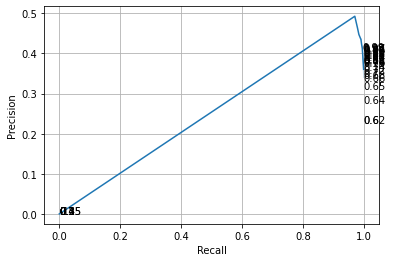

##################### high ##############################


/home/medha/sgml/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


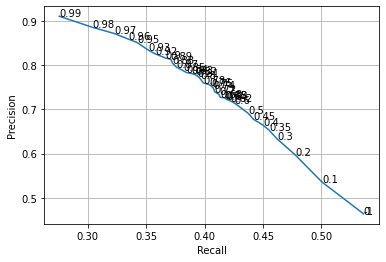

##################### wiggle ##############################


/home/medha/sgml/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


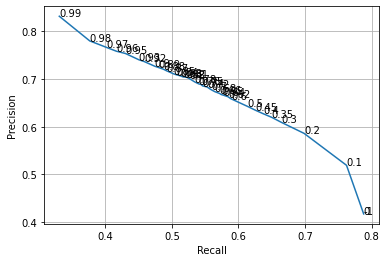

##################### mid ##############################


/home/medha/sgml/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


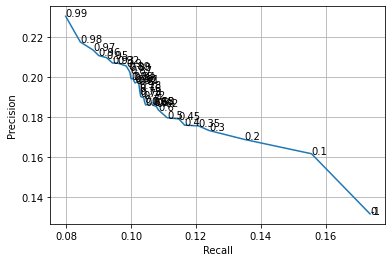

In [31]:
for model in models:
    print("#####################",model, "##############################")
    sns.lineplot(recall[model], precision[model])
    plt.ylabel("Precision")
    plt.xlabel("Recall")
    for i in range(len(thresolds)):
        plt.text(recall[model][i],precision[model][i], thresolds[i])
    plt.grid()
    plt.show()

In [35]:
models

{'low': 'low_90k_00125',
 'high': 'high_90k_00125',
 'wiggle': 'wiggle_90k_00125',
 'mid': 'mid_90k_00125'}

### Calculate F1 Scores

In [21]:
f1 = {}
for model in models:
    f1[model] = []
    precision_list = precision[model]
    recall_list = recall[model]
    for thresh in range(len(thresolds)):
        try:
            f1_score = 2 * (precision_list[thresh] * recall_list[thresh]) / (precision_list[thresh] + recall_list[thresh])
        except:
            f1_score = 0
        f1[model].append(f1_score)
        

In [37]:
mean = {}
for model in models:
    mean[model] = []
    precision_list = precision[model]
    recall_list = recall[model]
    for thresh in range(len(thresolds)):
        try:
            mean_score =  (1*precision_list[thresh] + 1*recall_list[thresh]) / 2
        except:
            mean_score = 0
        mean[model].append(mean_score)
        

In [49]:
list(models.keys())[1:]

['high', 'wiggle', 'mid']

### Finding the Thresholds for Each of the Models for max criteria

In [38]:
for model in list(models.keys())[1:]:
    print("#####################",model, "##############################")
    print()
    precision_list = precision[model]
    recall_list = recall[model]
    f1_list = f1[model]
    mean_list = mean[model]
    # calculate threshold index at maximum precision
    max_prec_id = np.argmax(precision_list)
    # calculate threshold index at maximum recall
    max_recall_id = np.argmax(recall_list)
    # calculate threshold index at maximum F1 Score
    max_f1_id = np.argmax(f1_list)
    # calculate threshold index at maximum mean Score
    max_mean_id = np.argmax(mean_list)
    
    print("#######Criteria: MAX PRECISION#####")
    print("Threshold: ", thresolds[max_prec_id])
    print("Precsion: ",  precision_list[max_prec_id], "Recall: ", recall_list[max_prec_id])
    print()
    
    print("#######Criteria: MAX RECALL#####")
    print("Threshold: ", thresolds[max_recall_id])
    print("Precsion: ",  precision_list[max_recall_id], "Recall: ", recall_list[max_recall_id])
    print()
    
    print("#######Criteria: MAX F1 SCORE#####")
    print("Threshold: ", thresolds[max_f1_id])
    print("Precsion: ",  precision_list[max_f1_id], "Recall: ", recall_list[max_f1_id])
    print()
    
    print("#######Criteria: MAX Mean SCORE#####")
    print("Threshold: ", thresolds[max_mean_id])
    print("Precsion: ",  precision_list[max_mean_id], "Recall: ", recall_list[max_mean_id])
    print()
    
    try:
        # calculate threshold index at maximum recall with a min precision of 60
        df_60 = pd.DataFrame()
        df_60['precision'] = precision_list
        df_60['recall'] = recall_list
        df_60['threshold'] = thresolds
        df_prec_60 = df_60[df_60["precision"]>=0.60].reset_index()
        max_recall_id_prec_60 = np.argmax(df_prec_60["recall"].tolist())

        print("#######Criteria: MAX RECALL WITH MIN PRECISION 0.60#####")
        print("Threshold: ", df_prec_60['threshold'][max_recall_id_prec_60])
        print("Precsion: ",  df_prec_60['precision'][max_recall_id_prec_60], "Recall: ", df_prec_60['recall'][max_recall_id_prec_60])
        print()

        # calculate threshold index at maximum recall with a min precision of 70
        df_70 = pd.DataFrame()
        df_70['precision'] = precision_list
        df_70['recall'] = recall_list
        df_70['threshold'] = thresolds
        df_prec_70 = df_70[df_70["precision"]>=0.70].reset_index()
        max_recall_id_prec_70 = np.argmax(df_prec_70["recall"].tolist())

        print("#######Criteria: MAX RECALL WITH MIN PRECISION 0.60#####")
        print("Threshold: ", df_prec_70['threshold'][max_recall_id_prec_70])
        print("Precsion: ",  df_prec_70['precision'][max_recall_id_prec_70], "Recall: ", df_prec_70['recall'][max_recall_id_prec_70])
    except:
        continue
    


##################### high ##############################

#######Criteria: MAX PRECISION#####
Threshold:  0.99
Precsion:  0.9114052953156823 Recall:  0.27563905143209116

#######Criteria: MAX RECALL#####
Threshold:  -1
Precsion:  0.46315509444001063 Recall:  0.5361872497690175

#######Criteria: MAX F1 SCORE#####
Threshold:  0.4
Precsion:  0.664695177434031 Recall:  0.44995380351093317

#######Criteria: MAX Mean SCORE#####
Threshold:  0.97
Precsion:  0.8725 Recall:  0.32245149368647985

#######Criteria: MAX RECALL WITH MIN PRECISION 0.60#####
Threshold:  0.3
Precsion:  0.6337135614702155 Recall:  0.4619648906683092

#######Criteria: MAX RECALL WITH MIN PRECISION 0.60#####
Threshold:  0.6
Precsion:  0.7139907072792979 Recall:  0.4259316291961811
##################### wiggle ##############################

#######Criteria: MAX PRECISION#####
Threshold:  0.99
Precsion:  0.8316768194934274 Recall:  0.3306986231514533

#######Criteria: MAX RECALL#####
Threshold:  -1
Precsion:  0.41727978400

In [51]:
import json
with open('precision_val_orgmodel.json', 'w') as f:
    json.dump(precision, f)
with open('recall_val_orgmodel.json', 'w') as f:
    json.dump(recall, f)

In [20]:
json_file_path = "precision_val_orgmodel.json"

with open(json_file_path, 'r') as j:
     precision = json.loads(j.read())

json_file_path = "recall_val_orgmodel.json"

with open(json_file_path, 'r') as j:
     recall = json.loads(j.read())

